In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import  LinearRegression
from sklearn.feature_selection import  f_regression
from sklearn.tree import  DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize, scale, StandardScaler
from sklearn.ensemble import  RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBRegressor,plot_importance
import itertools
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Contents
- EDA
- Feature Engineering & Modelling
    - Feature Selection Approach 1 - Backward Elimination
    - Feature Selection Approach 2 - PCA
    - Feature Selection Approach 3 - F Test
- Future Improvements

# EDA

In [4]:
features =  pd.read_parquet('features.parquet')
target =  pd.read_parquet('target.parquet')
features.shape
features.head()
target.shape
target.head()

(10000, 1000)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1990-01-01,0.943503,2.285943,-0.676534,-1.073370,0.222805,0.549741,-0.593814,2.178840,0.352440,0.201713,...,0.096125,0.953935,0.301930,-0.362019,-1.161094,0.653639,1.052906,0.412227,-0.554256,1.024348
1990-01-02,0.757759,0.420328,-0.171919,-0.256779,-0.026867,0.469453,-2.414748,-1.230617,-1.632244,-1.584294,...,1.929657,-0.209801,-0.152551,-0.696473,1.722749,0.661907,-1.248569,1.736036,0.291525,-0.461472
1990-01-03,1.321828,0.338798,-0.056767,0.831892,-0.237888,-0.280212,-0.863612,-0.339115,-0.197328,0.885977,...,-0.920220,-0.984264,0.561081,2.038433,0.073335,-0.187716,-0.597649,-0.091542,1.148625,0.413747
1990-01-04,0.791808,-1.413861,0.796525,-1.579936,1.093092,0.177056,-0.221590,0.454206,-0.883866,0.225825,...,-1.637996,-0.037544,0.299472,-1.459668,-1.006607,-1.116544,0.165441,0.946803,-0.738654,-0.376507
1990-01-05,0.703500,-1.096535,0.303689,0.841819,-1.199948,-0.336136,1.417628,0.440125,-1.757652,2.210187,...,-1.900305,-0.473095,-0.084830,-0.108897,-0.971338,-1.226582,1.515971,0.778013,1.755896,2.025973


(10000, 1)

,target
1990-01-01,0.187237
1990-01-02,0.583561
1990-01-03,0.584215
1990-01-04,-0.014664
1990-01-05,-0.896113


In [8]:
# check index alignment
target.index = pd.to_datetime(target.index)
features.index = pd.to_datetime(features.index)
target.loc[~target.index.isin(features.index)]
features.loc[~features.index.isin(target.index)]


,target


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999


Featues and target index are well aligned

In [16]:
#check features' distribution
features_stats = features.describe()
features_stats

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.008572,-0.004498,-0.022229,0.002005,-0.016317,-0.005396,-0.003207,0.009475,-0.002046,0.006495,...,-0.017317,0.010534,-0.000375,0.002697,0.010356,0.001716,-0.007880,0.020026,-0.002291,0.008746
std,1.005154,1.008740,0.999850,0.996446,1.007743,0.995324,1.006088,1.005719,0.998800,1.004791,...,1.008889,1.009862,0.995585,0.992234,1.002221,1.000776,1.011804,0.985852,0.990585,1.006371
min,-4.128442,-3.387357,-3.947738,-4.275218,-3.750825,-4.005987,-3.500360,-4.202960,-3.943426,-3.929699,...,-3.856198,-3.685112,-4.002535,-3.794738,-4.013891,-4.665611,-4.019283,-3.437754,-3.650274,-3.971332
25%,-0.701132,-0.690195,-0.717003,-0.663236,-0.695181,-0.673877,-0.681253,-0.665722,-0.674646,-0.661539,...,-0.703154,-0.673324,-0.669939,-0.648356,-0.680834,-0.661215,-0.682082,-0.653697,-0.660055,-0.674628
50%,-0.010331,0.001522,-0.007906,-0.008002,-0.010563,-0.009045,-0.011091,0.021238,0.005896,0.004434,...,-0.017224,0.001070,0.008198,-0.001022,0.012962,-0.005112,-0.013811,0.008793,-0.005615,0.016268
75%,0.678265,0.685403,0.653787,0.670506,0.667773,0.659895,0.692270,0.687297,0.668090,0.670568,...,0.663500,0.695344,0.653991,0.666124,0.679689,0.680443,0.671083,0.677428,0.661501,0.676353
max,4.965782,3.379153,3.525343,4.831867,4.060638,3.649687,3.781824,4.060110,3.920276,4.175207,...,3.465817,4.290298,3.966707,3.691513,4.102348,3.540362,3.685299,3.970515,3.956392,3.886037


In [20]:
#check features's distribution of standard deviation -> relatively centered around 1
features_stats.loc['std'].min()
features_stats.loc['std'].max()


0.9744781745140917

1.4244663877067634

In [21]:
#check features's distribution of mean -> relatively centered around 0
features_stats.loc['mean'].min()
features_stats.loc['mean'].max()


-0.03329011564620238

0.040604694372431416

In [22]:
#check features's distribution of min and max -> relatively within similiar range
features_stats.loc['min'].min()
features_stats.loc['min'].max()

-6.8545829937010785

-3.1818716352192684

In [23]:
features_stats.loc['max'].min()
features_stats.loc['max'].max()

3.1806385819329415

5.224528213919469

In [15]:
#check nulls -> no nulls from features
features.isnull().sum().unique()


array([0], dtype=int64)

<AxesSubplot:>

<AxesSubplot:>

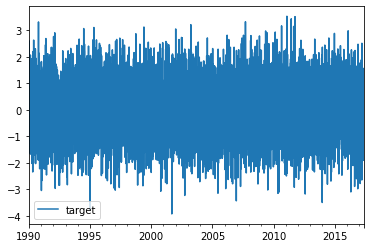

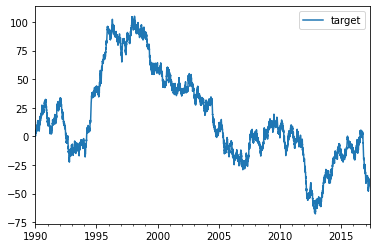

In [42]:
# visualizting time series plot
target.plot()
target.cumsum().plot()

# Feature Engineering & Modelling

Ideally, feature enginneering should be based on some business intuition or prior knowledge. However, given that I do not know the labels of each feature in the dataset, I applied pure data science and statistical approach to extract features and reduce dimension. 

I applied 3 approaches for feature selection and dimensional reduction - backward elimination, PCA, and F test.

For modelling evaluation, I looked at both parametrical metrics and path metrics. For parametrical metrics, I used MAE as the mian evaluation metric, with MSE and R squared as reference points. For path metrics, I compared the path between target value and predicted value to assess the predictive power from the predicted value. Models are hyperparameter-tuned to find the best model parameters.

The results shows features selcted from backward elimination worked best with decision tree models, with MAE of 0.79. By comparing the time series cumsum charts, the predicted value is relatively close to the target value, with a trough around 2013, and improvements afterwards.

By comparing correlation by shifting predicted value ahead to understand how many days is predicted value ahead of the target value, we can see the correlation is largest when predicted value is shifted ahead by 3 days, indicating the predicitve power of 3 days.

Features selected from backward elimination are in total 200 features. To name a few column identifiers, it incldues columns- '979', '46', '202', '433', '665', '7', '669', '279', '310', '208', '12', '63', '360', '345', '459', '575', '606', '8', '280', '759', etc.

## Feature Selection Approach 1 - Backward Elimination

In [64]:
# split between training and test data set
train_size = 0.7
train_len = int(len(features.index) * train_size)
test_len = int(len(features.index) * (1-train_size))
xtrain = features.iloc[:train_len]
xtest = features.iloc[train_len:]
ytrain = target.iloc[:train_len]
ytest = target.iloc[train_len:]
xtrain.shape
xtrain.head()
xtrain.tail()
xtest.shape
xtest.head()
ytrain.shape
ytest.shape

(7000, 1000)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1990-01-01,0.943503,2.285943,-0.676534,-1.073370,0.222805,0.549741,-0.593814,2.178840,0.352440,0.201713,...,0.096125,0.953935,0.301930,-0.362019,-1.161094,0.653639,1.052906,0.412227,-0.554256,1.024348
1990-01-02,0.757759,0.420328,-0.171919,-0.256779,-0.026867,0.469453,-2.414748,-1.230617,-1.632244,-1.584294,...,1.929657,-0.209801,-0.152551,-0.696473,1.722749,0.661907,-1.248569,1.736036,0.291525,-0.461472
1990-01-03,1.321828,0.338798,-0.056767,0.831892,-0.237888,-0.280212,-0.863612,-0.339115,-0.197328,0.885977,...,-0.920220,-0.984264,0.561081,2.038433,0.073335,-0.187716,-0.597649,-0.091542,1.148625,0.413747
1990-01-04,0.791808,-1.413861,0.796525,-1.579936,1.093092,0.177056,-0.221590,0.454206,-0.883866,0.225825,...,-1.637996,-0.037544,0.299472,-1.459668,-1.006607,-1.116544,0.165441,0.946803,-0.738654,-0.376507
1990-01-05,0.703500,-1.096535,0.303689,0.841819,-1.199948,-0.336136,1.417628,0.440125,-1.757652,2.210187,...,-1.900305,-0.473095,-0.084830,-0.108897,-0.971338,-1.226582,1.515971,0.778013,1.755896,2.025973


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2009-02-25,0.080533,0.256312,0.559213,1.508573,-0.952171,-0.063566,-2.106840,1.232395,1.730807,-1.178106,...,0.020103,1.339799,0.368437,-1.492337,1.643798,1.277063,0.327296,0.701744,0.542135,-1.219524
2009-02-26,-0.540102,-1.303380,-0.708246,-0.882363,0.587085,0.489231,-0.034246,-1.309256,-1.398321,0.729492,...,0.039901,-0.068265,0.573422,-0.426901,-2.334531,0.265245,0.620735,-1.373623,0.601200,0.966787
2009-02-27,0.361646,-2.647456,0.687982,2.068186,1.602446,0.698092,0.875561,-1.077449,-0.402130,0.377512,...,-0.008212,1.080585,-0.493124,-0.357810,0.675277,-2.370957,-0.081190,2.212157,-0.707208,-0.943612
2009-02-28,2.320730,-1.205485,0.891637,0.290391,-1.215879,1.059935,-0.714370,0.033922,-0.347714,0.185106,...,0.876502,1.333054,0.118427,-0.167022,-0.740728,-0.122609,1.360370,-1.604320,0.187666,0.184501
2009-03-01,-0.489193,1.548652,-2.301989,-0.230718,-1.228268,-0.208020,1.476721,-1.531453,-0.298059,-0.735896,...,-0.934719,2.551681,0.045813,0.646710,-0.853424,0.314131,-2.215948,0.488905,-0.555551,-1.060801


(3000, 1000)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2009-03-02,0.959959,-0.135630,-0.719417,0.633197,0.162678,0.954001,0.218915,-1.077025,0.337764,2.078492,...,-0.226721,-0.671868,1.767070,-0.334827,-0.043890,-0.037443,-0.318301,1.047346,-0.008123,-0.391694
2009-03-03,0.151288,0.577267,0.582642,0.868066,0.967827,-0.705060,-1.429996,-0.365355,1.430644,-1.010319,...,-0.514840,-0.477410,-0.585001,1.156334,1.500593,0.622640,1.537334,-0.996524,0.136070,-1.243357
2009-03-04,-0.762183,0.558467,1.570452,-0.161511,0.755039,0.066518,-0.123605,-0.244742,0.257167,0.235104,...,-0.238711,0.095388,0.171662,-0.638782,-1.391247,0.012936,-0.526739,-0.115704,2.124018,-0.842850
2009-03-05,0.142225,0.432812,0.334751,1.324464,1.227664,-0.825051,-0.250942,0.842679,0.600740,0.144661,...,0.035249,-0.137280,-1.828886,-0.345241,-1.724927,-0.103295,0.111466,-0.023077,-1.791797,-0.386819
2009-03-06,-0.320024,0.170332,-0.892417,0.113862,0.292723,-1.074066,-0.347674,1.159304,-1.054585,-1.011236,...,0.781884,-0.029404,-0.028342,-0.613715,0.788471,-0.821906,0.271830,-1.952343,0.718141,0.755541


(7000, 1)

(3000, 1)

Given that there are 1000 features in the dataset, and I dont have any prior which features should be included in the modelling, so I used backward elimination approach to select features. It starts with considering all the features in a simple model and removes the least significant feature iteratively.

In [30]:
# model evaluationn fundtion
def model_evaluation (ytrue, ypred, model_name, num_observations, num_features):
    print (f'***{model_name}***')
    r_squared = r2_score(y_pred=ypred, y_true = ytrue)
    adjusted_r_squared = 1-(1-r_squared)*(num_observations-1)/(num_observations-num_features-1)
    print(f'R squared:  {r_squared}')
    print(f'Adjusted R squared:  {adjusted_r_squared}')
    print(f'MSE:  {mean_squared_error(y_pred=ypred, y_true = ytrue)}')
    print(f'MAE:  {mean_absolute_error(y_pred=ypred, y_true = ytrue)}')

For model evaluation metrics, I output R squared, adjusted R squared, MSE, and MAE. Given that we want to see how well the predicted value can predict target value, and MAE is generally more robust to outliers, I choose MAE as the model evaluation metric, while keep other metrics as reference points.

In [65]:
# fit all features in a linear model to see if any less important features can be removed
linear_model = LinearRegression()
linear_model.fit(xtrain, ytrain)
linear_model_pred = linear_model.predict(xtest)
model_evaluation(ytrue = ytest, ypred = linear_model_pred, model_name='Linear Regression', 
                 num_observations =xtest.shape[0],num_features=xtest.shape[1] )

LinearRegression()

***Linear Regression***
R squared:  -0.17344157970784213
Adjusted R squared:  -0.7604558767102645
MSE:  1.1590475620509946
MAE:  0.8594806641537901


In [66]:
#feature importance
linear_model_feature_importance = pd.DataFrame(linear_model.coef_, columns = xtest.columns, index = ['Coefficient']).T
linear_model_feature_importance.sort_values('Coefficient')

,Coefficient
776,-0.054882
206,-0.040953
10,-0.033684
463,-0.031403
81,-0.030674
...,...
211,0.033871
292,0.033934
732,0.037534
871,0.037993


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'linear_model_pred Cumsum Plot'}>

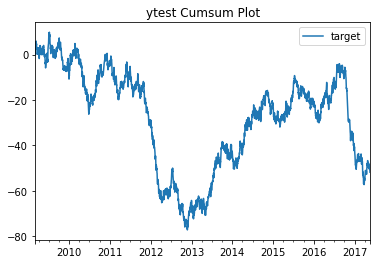

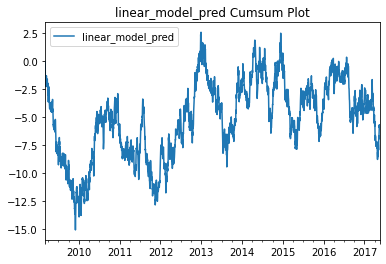

In [67]:
# comparing path
linear_model_pred_df = pd.DataFrame(linear_model_pred, columns = ['linear_model_pred'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
linear_model_pred_df.cumsum().plot(title = 'linear_model_pred Cumsum Plot')

Each feature has coefficient of roughly 0, which makes it hard to remove any features. In addition, the results also tells us linear model is not a good fit. With that, I further explored some non-linear models.

In [ ]:
# fit all features in Decision Trees

In [79]:
dt_model = DecisionTreeRegressor()
dt_model.fit(xtrain, ytrain)
dt_modell_pred = dt_model.predict(xtest)
model_evaluation(ytrue = ytest, ypred = dt_modell_pred, model_name='Decision Tree Regression', 
                 num_observations =xtest.shape[0],num_features=xtest.shape[1] )

DecisionTreeRegressor()

***Decision Tree Regression***
R squared:  -0.9521423060056222
Adjusted R squared:  -1.9287017387247927
MSE:  1.9281963581994093
MAE:  1.0991799863008054


C:\Users\sarahwang\AppData\Local\conda\conda\envs\mlenv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

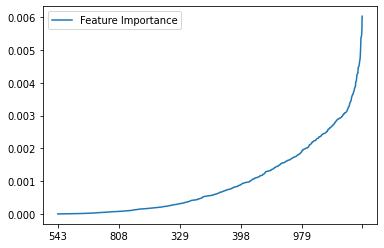

In [263]:
# feature importance
dt_model_feature_importance = pd.DataFrame(dt_model.feature_importances_, index = xtest.columns, columns = ['Feature Importance'])
dt_model_feature_importance = dt_model_feature_importance.sort_values('Feature Importance')
dt_model_feature_importance.plot()


After sorting features importance, features after 979 seems to come with higher feature importance. Therefore, I choose feature 979 as the cutoff points, and select features with larger feature importancen than feature 979. That gives us 200 features in total. It is a bit arbitrary in terms of the number of features selected. There is a tradeoff between selecting too much and too few number of features. If too few features are selected, model will be underfitting and not be able to pick up some importance variation from the training data. However, if too much features are selected, model will likely pick up noise from training data and not generalize well to test data. If more time is given, I can iterate more on the total number of features selected. 

The cumsum plot comparison between test data and predicted data is below. Although predicted data is not a perfect match of test data, it is able to pick up the overall trend, and is a leading indicator of the trough happened in 2013 in test dataset.

<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'decision_tree_model_pred Cumsum Plot'}>

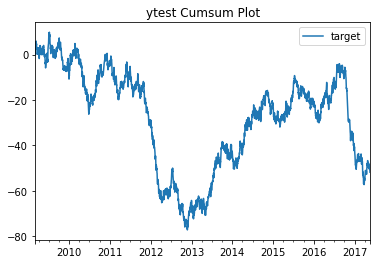

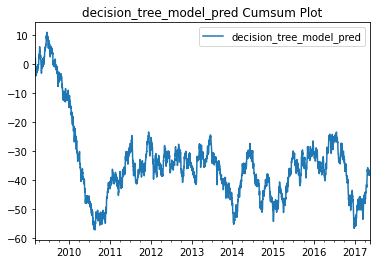

In [81]:
# comparing path
dt_model_pred_df = pd.DataFrame(dt_modell_pred, columns = ['decision_tree_model_pred'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
dt_model_pred_df.cumsum().plot(title = 'decision_tree_model_pred Cumsum Plot')

Based on finding above, I narrowed down to 200 features, and conduct time series cross validation and hyperperamerter tuning.

In [272]:
# feature selection
dt_variables = dt_model_feature_importance.loc['979':].index
dt_variables

Index(['979', '46', '202', '433', '665', '7', '669', '279', '310', '208',
       ...
       '12', '63', '360', '345', '459', '575', '606', '8', '280', '759'],
      dtype='object', length=200)

In [281]:
# training model
dt_model = DecisionTreeRegressor()
dt_model.fit(xtrain[dt_variables], ytrain)
dt_modell_pred = dt_model.predict(xtest[dt_variables])
model_evaluation(ytrue = ytest, ypred = dt_modell_pred, model_name='Decision Tree Regression - Feature Selection', 
                 num_observations =xtest.shape[0],num_features=len(dt_variables) )

DecisionTreeRegressor()

***Decision Tree Regression - Feature Selection***
R squared:  -1.01668382108633
Adjusted R squared:  -1.160784129845625
MSE:  1.9919461749768212
MAE:  1.1268329554391587


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'decision_tree_model_feature_selected Cumsum Plot'}>

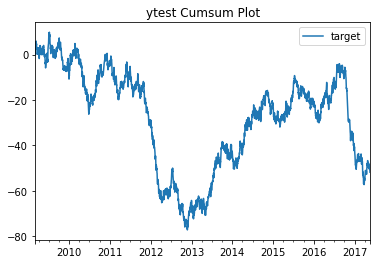

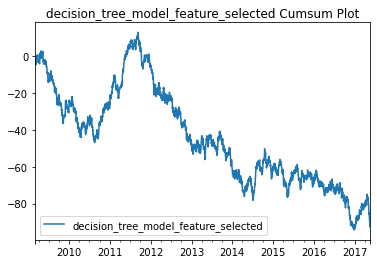

In [282]:
# comparing path
dt_modell_pred = pd.DataFrame(dt_modell_pred, columns = ['decision_tree_model_feature_selected'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
dt_modell_pred.cumsum().plot(title = 'decision_tree_model_feature_selected Cumsum Plot')

In [317]:
# cross valication and hyperparameter tuning
model = DecisionTreeRegressor()
param_search = { 
    'min_samples_leaf': [5, 10,20],
    'max_depth' : [2, 3, 5, 10, 20]
}
tscv = TimeSeriesSplit(n_splits=4)
gsearch = GridSearchCV(estimator=model, cv=tscxv, param_grid=param_search, scoring = 'neg_mean_absolute_error', n_jobs = -1, verbose=1)
gsearch.fit(xtrain[dt_variables], ytrain)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    2.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20]},
             scoring='neg_mean_absolute_error', verbose=1)

In [276]:
best_score

-0.0234340931793679

In [302]:
best_model_dt = best_model
best_model_dt

DecisionTreeRegressor(max_depth=2, min_samples_leaf=20)

In [288]:
# parametrical model evaluation
best_model_dt_pred = gsearch.predict(xtest[dt_variables])
model_evaluation(ytrue = ytest, ypred = best_model_dt_pred, model_name='Decision Tree Regression - Tuned', 
                 num_observations =xtest.shape[0],num_features=(len(dt_variables)) )

***Decision Tree Regression - Tuned***
R squared:  -0.008436640082603253
Adjusted R squared:  -0.08049356327535806
MSE:  0.9960666550282343
MAE:  0.7914753593054723


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'decision_tree_model_tuned Cumsum Plot'}>

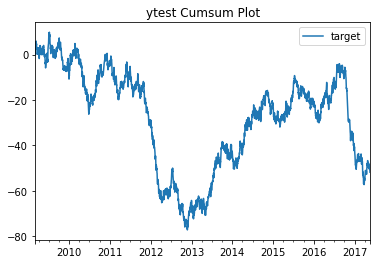

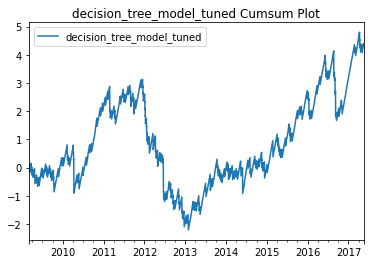

In [289]:
# comparing path
best_model_dt_pred = pd.DataFrame(best_model_dt_pred, columns = ['decision_tree_model_tuned'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
best_model_dt_pred.cumsum().plot(title = 'decision_tree_model_tuned Cumsum Plot')

<AxesSubplot:>

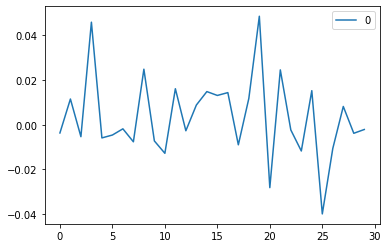

In [297]:
# comparing shifted correlation
correlation = []
for day in range(30):
    best_model_dt_pred_shift = best_model_dt_pred.shift(-day)
    corr = pd.concat([ytest,best_model_dt_pred_shift], axis = 1).corr()
    corr = corr.iloc[0, 1]
    correlation.append(corr)
pd.DataFrame(correlation).plot()

The hyperparameter tuning gives us max_depth=2, min_samples_leaf=20. After feature selection, MAE is increased from 1.09 to 1.12, which is expected because the total number of features are reduced significantly. However, after hyperparamter tuning, MAE is decreased from 1.12 to 0.79, or ~30%, which indicates very good improvement. 

By comparing the time series cumsum charts, the predicted value is much closer than the target value, with a trough around 2013, and improvements afterwards.

By comparing correlation by shifting predicted value ahead to understand how many days is predicted value ahead of the target value, we can see the correlation is largest when predicted value is shifted ahead by 3 days.

<AxesSubplot:ylabel='Frequency'>

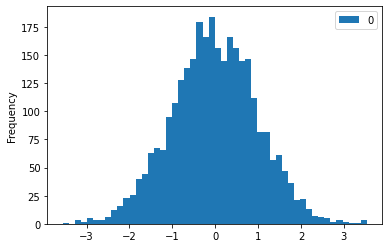

In [324]:
#residual analysis
residual = ytest.values - best_model_dt_pred.values
residual = pd.DataFrame(residual, index = ytest.index)
residual.plot.hist(bins = 50)

The residual analysis shows the residuals are following a relativel normal distribution.

I further explored random forest model, and applied cross validation and hyperparameter tuning. Although it gives similiar MAE, the path is not following similiar trend as target value. Therefore, it's predicitve power is not as good as decision tree.

In [327]:
#random forest model
rf_model = RandomForestRegressor(n_estimators = 200,n_jobs=-1, verbose=1)

rf_model.fit(xtrain[dt_variables], ytrain)
rf_model_pred = rf_model.predict(xtest[dt_variables])
model_evaluation(ytrue = ytest, ypred = rf_model_pred, model_name='Random Forest Regression', 
                 num_observations =len(xtest.index),num_features=len(dt_variables) )

C:\Users\sarahwang\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   51.8s finished


RandomForestRegressor(n_estimators=200, n_jobs=-1, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


***Random Forest Regression***
R squared:  -0.00696132731275978
Adjusted R squared:  -0.0789128333729785
MSE:  0.9946094391781061
MAE:  0.7915737675942283


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'random_forest_model Cumsum Plot'}>

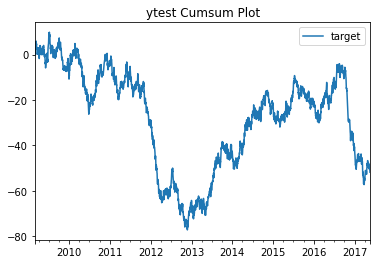

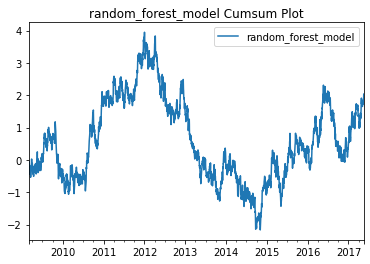

In [328]:
# comparing path
rf_model_pred = pd.DataFrame(rf_model_pred, columns = ['random_forest_model'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
rf_model_pred.cumsum().plot(title = 'random_forest_model Cumsum Plot')

In [333]:
# hyperparameter tuning random forest model
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [300, 500,800],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 5]
}
tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_absolute_error', n_jobs = -1, verbose=1)
gsearch.fit(xtrain[dt_variables], ytrain)
best_score_rf = gsearch.best_score_
best_model_rf = gsearch.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   44.5s finished
C:\Users\sarahwang\AppData\Local\conda\conda\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [300, 500, 800]},
             scoring='neg_mean_absolute_error', verbose=1)

***Random Forest Regression - Tuned***
R squared:  -0.0011367312224994652
Adjusted R squared:  -0.07267204606512179
MSE:  0.9888562904785102
MAE:  0.790852560656511


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'random_forest_model_pred_tuned Cumsum Plot'}>

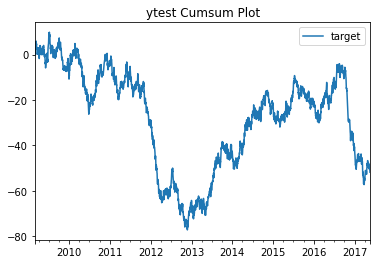

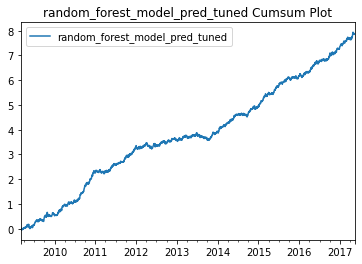

In [334]:
# parametrical and path evaluation
best_model_rf_pred = best_model_rf.predict(xtest[dt_variables])
model_evaluation(ytrue = ytest, ypred = best_model_rf_pred, model_name='Random Forest Regression - Tuned', 
num_observations =xtest.shape[0],num_features=len(dt_variables) )
best_model_rf_pred = pd.DataFrame(best_model_rf_pred, columns = ['random_forest_model_pred_tuned'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
best_model_rf_pred.cumsum().plot(title = 'random_forest_model_pred_tuned Cumsum Plot')

## Feature Selection Approach 2 - PCA

PCA is sensitive to outliers. However, from EDA's finding, feature values are relatively centered around 0 with standard deviation of 1. Therefore, no additional standardization is applied here.

array([[ 0.17945755, -1.12927502, -0.59684829, ..., -0.60144892,
        -0.44063674, -0.84106277],
       [ 1.03235117, -0.34367945, -0.08029337, ..., -0.53606011,
         0.5573338 , -1.03119749],
       [-1.42084209,  1.83852814, -0.09070276, ...,  0.4935402 ,
        -0.34092054,  0.47135213],
       ...,
       [ 1.83934379,  0.86269011, -2.32162809, ..., -1.18960517,
         0.3229724 ,  0.47536908],
       [ 1.48383014, -0.78668168,  0.67887347, ...,  0.57471618,
        -0.7546603 ,  1.45531898],
       [ 4.06684337,  0.82650281, -1.54947147, ..., -0.80824267,
         0.38909102,  1.03221562]])

<AxesSubplot:>

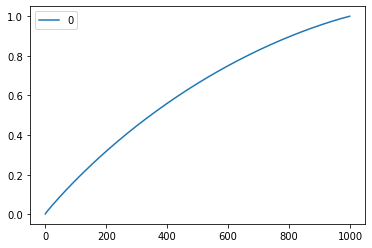

In [88]:
pca = PCA()
pca.fit_transform(xtrain)
explained_variance = pca.explained_variance_ratio_.cumsum()
pd.DataFrame(explained_variance).plot()

From explained variance plot, we can see 600 PC components can explain around 80% of variance, and 400 PC components can explain around 60% of variance. I explored both 400 and 600 PC components. PC components are fed into both decition tree and random forests models. However, the predictive power is not as good as features selected from backward elimination, even if with larger number of features feeding into the model. In addition, PCA feature selection uses pure statistical method and therefore not as easy to explain as backward elimination. Therefore, I do not recommend using PCA approach here.

<AxesSubplot:>

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400
1990-01-01,0.252953,-1.098897,-0.574897,0.036611,-2.138887,1.528684,2.492806,-2.830132,-1.558161,0.834826,...,-0.893832,-0.949652,-0.816841,0.441654,-1.318831,0.073631,-0.621655,2.321012,0.883248,-0.247504
1990-01-02,1.030264,-0.337603,-0.061139,-1.543160,-0.795320,0.307204,-1.304508,-0.337957,2.194081,0.671790,...,-0.249587,-0.588141,-0.281783,-0.410675,-0.021433,1.403078,1.685476,0.669435,-0.468406,1.542834
1990-01-03,-1.430764,1.799173,-0.077983,0.828443,0.318469,0.687379,-1.786107,1.659283,1.176488,0.605406,...,-0.448824,-0.036060,-0.257115,0.195750,0.160328,0.303319,-1.880752,0.272730,0.558066,-0.822875
1990-01-04,-0.351997,-2.516385,-1.633010,0.889283,0.394200,-1.803610,0.211354,-0.035988,-1.440795,-0.027177,...,0.257619,-0.473118,0.190201,0.231085,-1.418744,0.680000,-0.292671,0.212459,-0.106537,-1.075538
1990-01-05,2.468003,1.763358,0.863900,0.290713,-0.965205,0.608781,-1.028250,0.299138,-0.694749,1.266748,...,0.528094,-2.504844,0.079009,-1.028226,-0.715864,-1.299968,-0.078931,1.462993,-0.253310,-0.892822


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1990-01-01,0.943503,2.285943,-0.676534,-1.073370,0.222805,0.549741,-0.593814,2.178840,0.352440,0.201713,...,0.096125,0.953935,0.301930,-0.362019,-1.161094,0.653639,1.052906,0.412227,-0.554256,1.024348
1990-01-02,0.757759,0.420328,-0.171919,-0.256779,-0.026867,0.469453,-2.414748,-1.230617,-1.632244,-1.584294,...,1.929657,-0.209801,-0.152551,-0.696473,1.722749,0.661907,-1.248569,1.736036,0.291525,-0.461472
1990-01-03,1.321828,0.338798,-0.056767,0.831892,-0.237888,-0.280212,-0.863612,-0.339115,-0.197328,0.885977,...,-0.920220,-0.984264,0.561081,2.038433,0.073335,-0.187716,-0.597649,-0.091542,1.148625,0.413747
1990-01-04,0.791808,-1.413861,0.796525,-1.579936,1.093092,0.177056,-0.221590,0.454206,-0.883866,0.225825,...,-1.637996,-0.037544,0.299472,-1.459668,-1.006607,-1.116544,0.165441,0.946803,-0.738654,-0.376507
1990-01-05,0.703500,-1.096535,0.303689,0.841819,-1.199948,-0.336136,1.417628,0.440125,-1.757652,2.210187,...,-1.900305,-0.473095,-0.084830,-0.108897,-0.971338,-1.226582,1.515971,0.778013,1.755896,2.025973


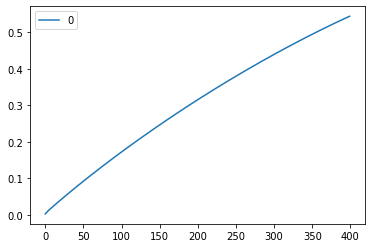

In [121]:
# apply PCA transformation
n_components = 400 #600
pca = PCA(n_components=n_components)
#scale()
xtrain_pca = pca.fit_transform(xtrain)
explained_variance = pca.explained_variance_ratio_.cumsum()
pd.DataFrame(explained_variance).plot()
xtrain_pca= pd.DataFrame(xtrain_pca, index = xtrain.index, columns = [f'PC{i}' for i in range(1, n_components+1)])
xtrain_pca.head()
xtrain.head()

In [122]:
xtest_pca =pca.transform(xtest)

xtest_pca= pd.DataFrame(xtest_pca, index = xtest.index, columns = [f'PC{i}' for i in range(1, n_components+1)])
xtest_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400
2009-03-02,-0.072211,-0.287085,-1.872718,0.222307,-0.241807,-1.274396,-0.199777,-0.005221,1.691172,-1.080143,...,-0.985289,0.632186,-0.010197,0.365642,1.103159,-0.136308,-1.113103,-1.575481,0.357797,0.879503
2009-03-03,0.957456,-1.098181,-2.561117,2.909922,0.040098,0.381405,-1.552356,0.817879,0.890737,0.489488,...,-0.581577,-0.599896,0.287347,1.404269,1.145281,-0.547011,-0.435171,1.124710,1.989364,-2.008779
2009-03-04,-0.263617,-0.549416,-0.033679,-0.097644,-2.574332,0.136702,-1.295529,-0.416146,-1.931950,-0.622131,...,0.552243,-1.652632,0.164179,1.230871,1.463661,-0.525304,0.826533,2.289825,-0.128944,-0.275610
2009-03-05,-1.141023,0.942032,-0.706696,-0.968742,-0.194228,0.818174,-0.658355,0.888473,-0.979949,-1.492108,...,-0.201191,-0.314172,-0.926733,0.297268,-0.634070,1.203263,-0.452858,-0.823014,0.745264,-0.951247
2009-03-06,1.350606,-0.519314,-1.193027,1.237281,-1.957851,-0.631425,-0.406732,-0.416530,-0.226963,-0.002865,...,-0.431948,1.400266,0.898876,1.121074,-0.230025,0.140005,0.661312,-1.745579,-0.291252,-0.508260


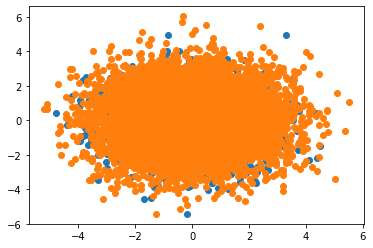

In [307]:
plt.scatter(xtest_pca['PC1'], xtest_pca['PC2'])
plt.scatter(xtrain_pca['PC1'], xtrain_pca['PC2'])

In [305]:
# decision tree model
dt_model_pca = DecisionTreeRegressor(max_depth=2, min_samples_leaf=20)
dt_model_pca.fit(xtrain_pca, ytrain)
dt_model_pca_pred = dt_model_pca.predict(xtest_pca)
model_evaluation(ytrue = ytest, ypred = dt_model_pca_pred, model_name='Decision Tree Regression - PCA', 
num_observations =xtest_pca.shape[0],num_features=xtest_pca.shape[1] )

DecisionTreeRegressor(max_depth=2, min_samples_leaf=20)

***Decision Tree Regression - PCA***
R squared:  -0.0026135625226502146
Adjusted R squared:  -0.15692115198362
MSE:  0.9903150062318983
MAE:  0.792213733754071


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'decision_tree_model_pca_pred Cumsum Plot'}>

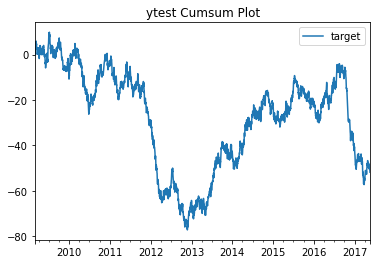

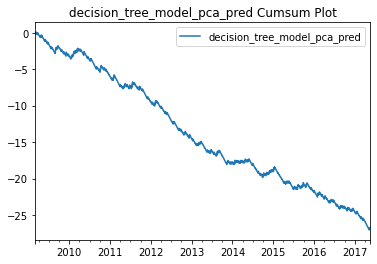

In [306]:
# comparing path
dt_model_pca_pred = pd.DataFrame(dt_model_pca_pred, columns = ['decision_tree_model_pca_pred'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
dt_model_pca_pred.cumsum().plot(title = 'decision_tree_model_pca_pred Cumsum Plot')

In [123]:
# random forest model
rf_model = RandomForestRegressor(n_estimators=200,n_jobs=-1, verbose=1)
rf_model.fit(xtrain_pca, ytrain)
rf_model_pca_pred = rf_model.predict(xtest_pca)
model_evaluation(ytrue = ytest, ypred = rf_model_pca_pred, model_name='Random Forest Regression with PCA', 
                 num_observations =xtest_pca.shape[0],num_features=xtest_pca.shape[1] )

C:\Users\sarahwang\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished


RandomForestRegressor(n_estimators=200, n_jobs=-1, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


***Random Forest Regression with PCA***
R squared:  -0.011079872952292735
Adjusted R squared:  -0.16669047286799765
MSE:  0.998677464689768
MAE:  0.7958436254138199


In [124]:
# feature importance
rf_model_feature_importance = pd.DataFrame(rf_model.feature_importances_, index = xtest_pca.columns, columns = ['Feature Importance'])
rf_model_feature_importance.sort_values('Feature Importance')

,Feature Importance
PC365,0.001774
PC186,0.001880
PC222,0.001906
PC356,0.001920
PC374,0.001935
...,...
PC211,0.003465
PC133,0.003499
PC241,0.003555
PC375,0.003570


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'random_forest_model_pca_pred Cumsum Plot'}>

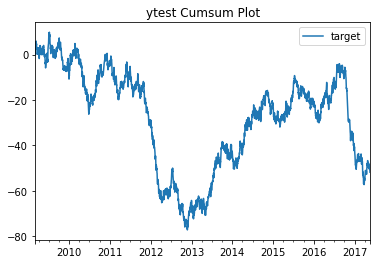

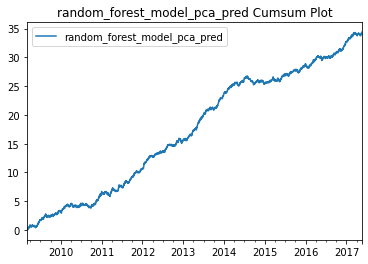

In [125]:
# comparing path
rf_model_pca_pred_df = pd.DataFrame(rf_model_pca_pred, columns = ['random_forest_model_pca_pred'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
rf_model_pca_pred_df.cumsum().plot(title = 'random_forest_model_pca_pred Cumsum Plot')

In [116]:
# parametrical evaluation
model_evaluation(ytrue = ytrain, ypred = rf_model_pca_pred_train, model_name='Random Forest Regression with PCA', 
                 num_observations =xtest_pca.shape[0],num_features=xtest_pca.shape[1] )

***Random Forest Regression with PCA***
R squared:  0.8576658638749923
Adjusted R squared:  0.8220674971909554
MSE:  0.14125849772609048
MAE:  0.2981964915661439


## Feature Selection Approach 3 - F Tests

In this approach, I used F test to select features with low p values (<0.05), indicatiing statistical significance. This gives us in total 41 features. However, after feeding into decision tree and random forest models, the results is not as good as Feature Selection Approach 1. Although models have low MAE, from their cumulative plot, it does not follow similiar trend as target values. Even after hyperparameter tuning, no significant improvement is seen. Therefore, I do not recommend this approach.

In [311]:
# select featues based on f test
fstats, pvalue = f_regression(xtrain, ytrain)
ftest = pd.DataFrame({'fstats': fstats, 'pvalue': pvalue}, index = xtrain.columns).sort_values('pvalue')
ftest_variables = ftest.loc[ftest.pvalue<0.05].index
ftest_variables
xtrain[ftest_variables]

C:\Users\sarahwang\AppData\Local\conda\conda\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Index(['776', '618', '206', '158', '732', '871', '292', '640', '442', '749',
       '938', '10', '403', '260', '881', '211', '268', '869', '775', '178',
       '559', '463', '552', '81', '955', '410', '184', '642', '173', '762',
       '920', '811', '910', '612', '720', '450', '844', '25', '3', '441',
       '120'],
      dtype='object')

,776,618,206,158,732,871,292,640,442,749,...,811,910,612,720,450,844,25,3,441,120
1990-01-01,-0.227936,-0.465178,-0.297621,1.006404,-1.093437,-0.649001,0.550444,1.774194,-1.515944,-0.561594,...,-0.781709,0.679142,0.869582,-0.308881,-0.467963,0.667437,1.510890,-1.073370,2.597097,0.126553
1990-01-02,-0.481188,1.041773,-1.026740,-0.688632,-0.439581,1.207707,1.087907,-0.234648,-0.197094,-0.784893,...,2.897564,1.220027,1.171265,0.981322,0.153408,-1.010582,0.373260,-0.256779,-0.363739,-1.521836
1990-01-03,1.138508,0.718281,-0.026192,-0.438797,-0.686851,-0.568006,-1.847071,-0.435950,-0.394541,0.662450,...,0.671237,-1.281614,-0.341883,-0.134791,0.510233,0.879878,1.391711,0.831892,-0.006696,-0.223706
1990-01-04,1.025163,1.072114,-0.515886,-0.443972,1.622397,0.862189,-0.126787,-0.731898,1.111505,0.222222,...,0.139765,-0.449534,-0.446463,1.737954,-0.062258,-0.943142,-1.565731,-1.579936,-0.777419,-0.616974
1990-01-05,-1.433555,0.829255,0.568712,0.457004,-0.597979,0.090619,-0.255352,1.856786,0.620677,-1.064848,...,-1.355073,-1.037848,-1.163756,-0.996904,1.544343,0.312428,0.326067,0.841819,0.207968,-0.813711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-02-25,-0.496776,-1.377735,-1.434283,0.234319,-0.772271,-0.576828,-1.358618,-1.504761,0.108626,-0.655701,...,-0.693702,-0.397487,-1.078521,0.492806,1.778749,-1.200872,0.387955,1.508573,-0.842099,-0.128645
2009-02-26,1.999662,1.032523,-1.040431,0.109480,0.247721,-0.860788,0.379328,0.433720,-1.512855,-1.038427,...,0.619705,0.080372,-0.334387,0.620365,0.439018,0.269475,-0.642235,-0.882363,-1.183506,1.148939
2009-02-27,0.083271,0.427335,0.726494,-0.367107,0.466143,-0.056467,0.420905,0.442335,0.005255,-0.983236,...,0.888475,0.941677,-0.499180,1.396125,0.698548,0.066974,-1.314761,2.068186,1.084416,0.683559
2009-02-28,-0.335527,0.066635,0.863913,-0.416191,0.150348,-1.873555,-0.881923,0.958165,0.020666,-0.184098,...,1.587274,0.411482,-0.654921,-1.917692,2.099153,-0.436519,-0.423449,0.290391,0.577946,-1.094103


In [312]:
#ramdom forest model
rf_model = RandomForestRegressor(n_estimators = 200,n_jobs=-1, verbose=1)

rf_model.fit(xtrain[ftest_variables], ytrain)
rf_model_pred = rf_model.predict(xtest[ftest_variables])
model_evaluation(ytrue = ytest, ypred = rf_model_pred, model_name='Random Forest Regression with F Tests', 
                 num_observations =len(xtest.index),num_features=len(ftest_variables) )

C:\Users\sarahwang\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.1s finished


RandomForestRegressor(n_estimators=200, n_jobs=-1, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


***Random Forest Regression with F Tests***
R squared:  -0.016738689842291432
Adjusted R squared:  -0.030831416780605858
MSE:  1.0042668677191706
MAE:  0.7973099982700552


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'random_forest_model_ftests Cumsum Plot'}>

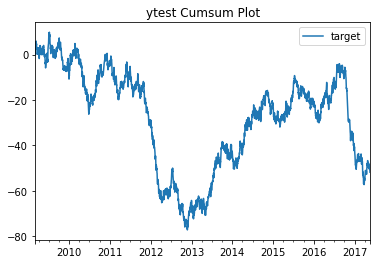

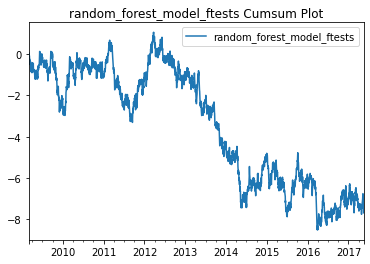

In [313]:
rf_model_pred = pd.DataFrame(rf_model_pred, columns = ['random_forest_model_ftests'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
rf_model_pred.cumsum().plot(title = 'random_forest_model_ftests Cumsum Plot')

In [315]:
# hyperparameter tuning random forest model
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [300, 500,800],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 5]
}
tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_absolute_error', n_jobs = -1, verbose=1)
gsearch.fit(xtrain[ftest_variables], ytrain)
best_score_rf_ftest = gsearch.best_score_
best_model_rf_ftest = gsearch.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   30.9s finished
C:\Users\sarahwang\AppData\Local\conda\conda\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [300, 500, 800]},
             scoring='neg_mean_absolute_error', verbose=1)

***Random Forest Regression - F Tests - Tuned***
R squared:  -0.0013365353887859754
Adjusted R squared:  -0.015215777427643351
MSE:  0.9890536437475836
MAE:  0.7907752190101807


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'random_forest_model_ftests_pred_tuned Cumsum Plot'}>

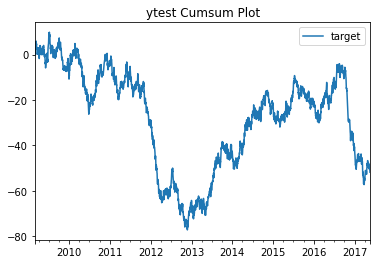

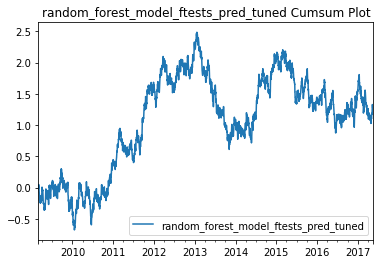

In [316]:
best_model_rf_pred = best_model_rf_ftest.predict(xtest[ftest_variables])
model_evaluation(ytrue = ytest, ypred = best_model_rf_pred, model_name='Random Forest Regression - F Tests - Tuned', 
num_observations =xtest.shape[0],num_features=len(ftest_variables) )
best_model_rf_pred = pd.DataFrame(best_model_rf_pred, columns = ['random_forest_model_ftests_pred_tuned'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
best_model_rf_pred.cumsum().plot(title = 'random_forest_model_ftests_pred_tuned Cumsum Plot')

DecisionTreeRegressor(max_depth=2, min_samples_leaf=20)

***Decision Tree Regression - F Tests***
R squared:  -0.007315088363564426
Adjusted R squared:  -0.02127719743148404
MSE:  0.9949588608200305
MAE:  0.7942184712381096


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'decision_tree_model_ftests_pred Cumsum Plot'}>

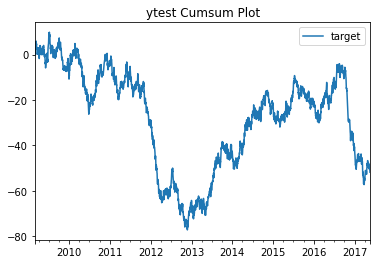

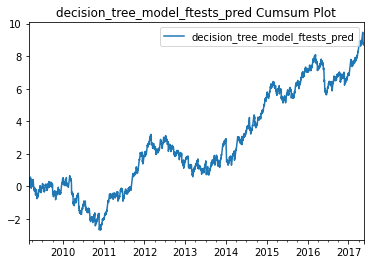

In [314]:
#decision tree model
dt_model_ftests = DecisionTreeRegressor(max_depth=2, min_samples_leaf=20)
dt_model_ftests.fit(xtrain[ftest_variables], ytrain)
dt_model_ftests_pred = dt_model_ftests.predict(xtest[ftest_variables])
model_evaluation(ytrue = ytest, ypred = dt_model_ftests_pred, model_name='Decision Tree Regression - F Tests', 
num_observations =xtest.shape[0],num_features=len(ftest_variables) )
dt_model_ftests_pred = pd.DataFrame(dt_model_ftests_pred, columns = ['decision_tree_model_ftests_pred'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
dt_model_ftests_pred.cumsum().plot(title = 'decision_tree_model_ftests_pred Cumsum Plot')

In [319]:
#hyper parameter tuning decision tree model
model = DecisionTreeRegressor()
param_search = { 
    'min_samples_leaf': [5, 10,20],
    'max_depth' : [2, 3, 5, 10, 20]
}
tscv = TimeSeriesSplit(n_splits=4)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_absolute_error', n_jobs = -1, verbose=1)
gsearch.fit(xtrain[ftest_variables], ytrain)
best_score_dt_ftest = gsearch.best_score_
best_model_dt_ftest = gsearch.best_estimator_

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20]},
             scoring='neg_mean_absolute_error', verbose=1)

***Decision Tree Regression - F Tests - Tuned***
R squared:  -0.005926643478817217
Adjusted R squared:  -0.019869507705535083
MSE:  0.9935874472903437
MAE:  0.7934716084050436


<AxesSubplot:title={'center':'ytest Cumsum Plot'}>

<AxesSubplot:title={'center':'decision_tree_model_ftests_pred_tuned Cumsum Plot'}>

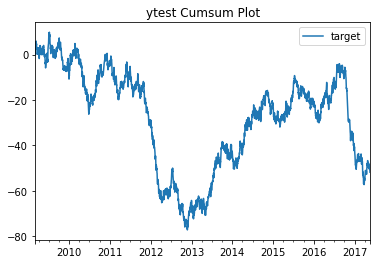

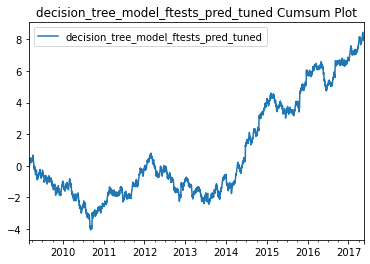

In [326]:
best_model_dt_ftest_pred = best_model_dt_ftest.predict(xtest[ftest_variables])
model_evaluation(ytrue = ytest, ypred = best_model_dt_ftest_pred, model_name='Decision Tree Regression - F Tests - Tuned', 
num_observations =xtest.shape[0],num_features=len(ftest_variables) )
best_model_dt_ftest_pred = pd.DataFrame(best_model_dt_ftest_pred, columns = ['decision_tree_model_ftests_pred_tuned'], index = ytest.index)

ytest.cumsum().plot(title = 'ytest Cumsum Plot')
best_model_dt_ftest_pred.cumsum().plot(title = 'decision_tree_model_ftests_pred_tuned Cumsum Plot')

# Future Improvements

If more time is given, I think it would be interesting to explore more complicated approaches such as neural network or LSTM. They may have better predicitive power on times series data.